In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.constants import e, m_e, h, k, pi, epsilon_0, hbar
from scipy.integrate import quad
from scipy.optimize import fmin, minimize_scalar
k_b = k

# Constants

In [2]:
k_b_eV = k_b / e # Boltzman constant in eV/K
lambda_R = 0.5
A_0 = 4.0*pi*m_e*k_b**2*e / h**3
A_G = lambda_R*A_0
B_Sch_eV_prefix = e/(4.0*pi*epsilon_0)

# System parameters

In [128]:
d = 1000.0*1.0E-9 # Gap spacing [m]
V = 100.0 # Voltage [V]
E_vac = -V/d # Electric field [V/m]
print(E_vac/1.0E8)
w_theta = 2.7 # Work function [eV]
T_k = 1250.0 # Temperature [K]

L = 1500.0E-9 # Side length [m]
A = L**2 # Emitter area [m^2]

time_step = 0.25E-12

-0.9999999999999999


# Define functions

In [129]:
def Elec_Supply(F: float) -> float:
    val = A_G*T_k**2
    return val

def Escape_Prop(F: float) -> float:
    delta_W = np.sqrt(B_Sch_eV_prefix*(-1.0*F)) # Units: mV*V/m = V^2, sqrt(V^2) = V = J/C = eV
    val = np.exp( -1.0*(w_theta - delta_W)/(k_b_eV*T_k) )
    return val

# Current density [J/m^2]
def Richardson_Dushman(F: float) -> float:
    val = Elec_Supply(F)*Escape_Prop(F)
    return val

In [130]:
J = Richardson_Dushman(E_vac)
print(J)

413.6410754847381


In [131]:
n = J*A*time_step/e
print(n)

0.0014522313079564642


# General thermal-field emission equation
## Kevin L. Jensen and Marc Cahay
http://dx.doi.org/10.1063/1.2193776

In [3]:
F = 4.3 # [eV/nm]
hbar_eV = 6.582119514E-16
h_eV = 4.135667662E-15
mu = 7.0 # [eV]
w_theta = 4.6 # [eV]
#w_phi = 3.0029646231176823
Q = e/(16*pi*epsilon_0)/1.0E-9 # [eV nm]
T_k = 800 # [K]
print(Q)

0.35999113379876363


In [4]:
def V(x, F):
    val = mu + w_theta - F*x - Q/x
    return val

In [15]:
'''Python program for golden section search.  This implementation
   reuses function evaluations, saving 1/2 of the evaluations per
   iteration, and returns a bounding interval.'''

import math
invphi = (math.sqrt(5) - 1) / 2 # 1/phi
invphi2 = (3 - math.sqrt(5)) / 2 # 1/phi^2

def gss(f,a,b,tol=1e-15):
    '''
    Golden section search.
    Given a function f with a single local minimum in
    the interval [a,b], gss returns a subset interval
    [c,d] that contains the minimum with d-c <= tol.

    example:
    >>> f = lambda x: (x-2)**2
    >>> a = 1
    >>> b = 5
    >>> tol = 1e-5
    >>> (c,d) = gss(f, a, b, tol)
    >>> print (c,d)
    (1.9999959837979107, 2.0000050911830893)
    '''

    (a,b)=(min(a,b),max(a,b))
    h = b - a
    if h <= tol: return (a,b)

    # required steps to achieve tolerance
    n = int(math.ceil(math.log(tol/h)/math.log(invphi)))

    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)

    for k in range(n-1):
        if yc < yd: # > for max or < for min
            b = d
            d = c
            yd = yc
            h = invphi*h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi*h
            d = a + invphi * h
            yd = f(d)

    if yc < yd: # > for max or < for min
        return (a,d)
    else:
        return (c,b)

In [44]:
def Calc_w_phi(F):
    f = lambda x: -V(x, F)
    a, b = gss(f, a=1.0E-9, b=15.0, tol=1.0E-15)
    v_max = -f(a)
    w_phi = v_max - mu
    return w_phi

In [106]:
def find_x_pm(E, F):
    A = F
    #B = E - mu - w_theta
    B = w_theta + mu - E
    C = Q
    x_p = (B + np.sqrt(B**2-4*A*C)) / (2*A)
    x_m = (B - np.sqrt(B**2-4*A*C)) / (2*A)
    
    # Return the larger number first (x_+ and x_-)
    if (x_p > x_m):
        return x_p, x_m
    else:
        return x_m, x_p
    
def theta_int(x, E, F):
    return np.sqrt(V(x, F) - E)

#def theta_int_an(x_p, x_m, E, F):
#    val_p = -Q*np.log(x_p) - F*x_p**2/2.0+(mu + w_theta - E)*x_p
#    val_m = -Q*np.log(x_m) - F*x_m**2/2.0+(mu + w_theta - E)*x_m
    
#    return val_p - val_m
    
def theta(E, F):
    w_phi = Calc_w_phi(F)
    if (E < (mu + w_phi)):
        x_p, x_m = find_x_pm(E, F)
        int_res, abserr = quad(theta_int, a=x_m, b=x_p, args=(E, F))
        val = 2.0/hbar_eV*np.sqrt(2.0*m_e)*int_res
        #val = 2.0/hbar_eV*np.sqrt(2.0*m_e)*theta_int_an(x_p, x_m, E, F)
    else:
        val = 1.0/(2.0*hbar_eV)*pi*np.sqrt(2.0*m_e)*Q**(1/4)*F**(-3/4)*(mu + w_phi - E)
    return val

def T_barrier(E):
    Beta_T = 1.0/(k_b_eV*T_k)
    C = m_e/(pi*Beta_T*h_eV**2)
    val = C*np.log(1 + np.exp(Beta_T*(mu - E)))
    return val

def D_barrier(E, F):
    val = 1.0/(1 + np.exp(theta(E, F)))
    #val = np.exp(-2*theta(E, F))
    return val

def TunnelBarrier(E, F):
    D = D_barrier(E, F)
    T = T_barrier(E)
    return T*D

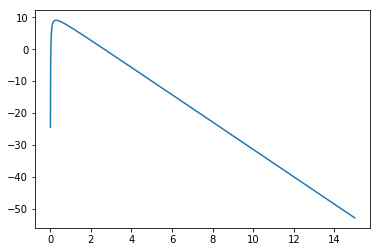

9.111654358751169


In [107]:
#F = 2000/1000.0E-9
#print(F)
x = np.linspace(0.01, 15.0, 5000)
V_arr = V(x, F)
plt.plot(x, V_arr)
plt.show()
print(np.max(V_arr))

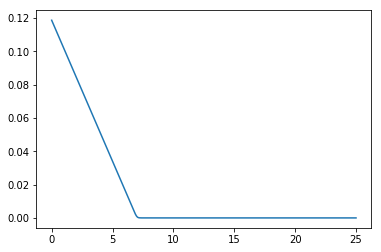

In [108]:
E_x = np.linspace(0.0, 25.0, 10000)
T_arr = T_barrier(E_x)
plt.plot(E_x, T_arr)
plt.show()

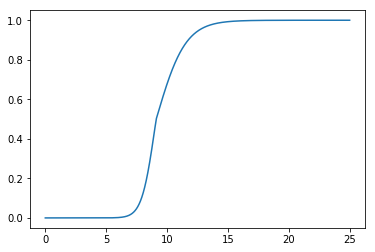

In [109]:
D_func = lambda x: D_barrier(x, F)
D_arr = np.array(list(map(D_func, E_x)))
plt.plot(E_x, D_arr)
plt.show()

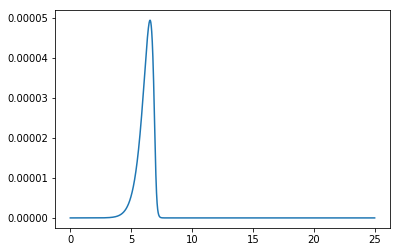

In [110]:
DT_func = lambda x: TunnelBarrier(x, F)
DT_arr = np.array(list(map(DT_func, E_x)))
plt.plot(E_x, DT_arr)
plt.show()

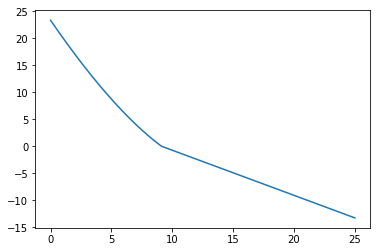

In [111]:
theta_func = lambda x: theta(x, F)
theta_arr = np.array(list(map(theta_func, E_x)))
plt.plot(E_x, theta_arr)
plt.show()

In [112]:
def Find_Em(F):
    DT_func = lambda x: -TunnelBarrier(x, F)
    a, b = gss(DT_func, a=0.0, b=20.0, tol=1.0E-25)
    #res = minimize_scalar(DT_func, bounds=[0,15], method='Brent')
    #a = res.x
    #a = fmin(DT_func, 0)
    return a

def Calc_Beta_F(F):
    theta_func = lambda x: theta(x, F)
    
    Em = Find_Em(F)
    
    h = 0.001
    val = -1.0*(-theta_func(Em + 2*h) + 8*theta_func(Em + h) - 8*theta_func(Em - h) + theta_func(Em - 2*h)) / (12*h)
    return val

def Calc_E0(F):
    Em = Find_Em(F)
    Beta_F = Calc_Beta_F(F)
    theta_func = lambda x: theta(x, F)
    val = Em + theta_func(Em)/Beta_F
    return val

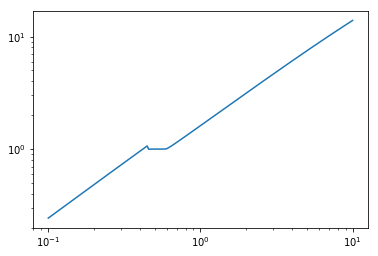

In [113]:
F_arr = np.linspace(0.1, 10.0, 1000)
Beta_T = 1.0/(k_b_eV*T_k)
Beta_F = np.array(list(map(Calc_Beta_F, F_arr)))
n = Beta_T/Beta_F

plt.loglog(F_arr, n)
plt.show()

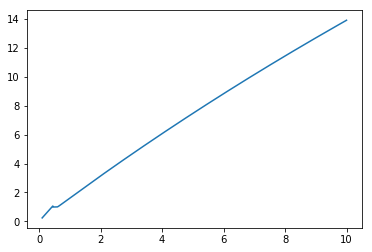

In [114]:
plt.plot(F_arr, n)
plt.show()

In [105]:
Beta_F = Calc_Beta_F(F)
print('Beta_F = ' + str(Beta_F))
E_0 = Calc_E0(F)
print('E_0 = ' + str(E_0))
s = Beta_F*(E_0 - mu)
print('s = ' + str(s))
print('Beta_F*E_0 = ' + str(Beta_F*E_0))
E_m = Find_Em(F)
print('E_m = ' + str(E_m))
print('w_phi = ' + str(Calc_w_phi(F)))

Beta_F = 3.963897041837046
E_0 = 8.220351449266419
s = 4.837347499748709
Beta_F*E_0 = 32.584626792608034
E_m = 6.756085051969777
w_phi = 2.1116576800330016
